In [0]:
#import dataset from the given link

import pandas as pd
URL_Tr = 'https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv'
dataset = pd.read_csv(URL_Tr, sep='\t')

In [0]:
review = dataset[['Phrase','Sentiment']]

In [543]:
# import necessary libraries and initialise the preprocessing parameters
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#Function to perform preprocessing of data, stemming lemmatisation, removal of punctuations etc.,

def preprocessing(review,remove_stopwords = True, stem_lem = 'word_net'):
  temp = review
  temp.loc[:,"Phrase"] = temp.Phrase.apply(lambda x : str.lower(x))
  temp.loc[:,"Phrase"] = temp.Phrase.apply(lambda x : " ".join(re.findall('[a-zA-Z]+',x)))
  if remove_stopwords == True:
    temp.loc[:,"Phrase"] = temp.Phrase.apply(lambda x : ' '.join(word for word in x.split() if word not in stop_words))
  if stem_lem =='word_net':
    temp.loc[:,"Phrase"] = temp.Phrase.apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))
  elif stem_lem == 'lancaster':
    temp.loc[:,"Phrase"] = temp.Phrase.apply(lambda x: " ".join([lancaster.stem(word) for word in x.split()]))
  elif stem_lem == 'porter':
    temp.loc[:,"Phrase"] = temp.Phrase.apply(lambda x: " ".join([porter.stem(word) for word in x.split()]))
  return temp

In [545]:
# The entire dataset is preprocessed and this does not result in dataleakage hence done together
preprocessed_review = preprocessing(review,remove_stopwords=True,stem_lem='word_net')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [546]:
preprocessed_review.head()

,Phrase,Sentiment
0,series escapade demonstrating adage good goose...,1
1,series escapade demonstrating adage good goose,2
2,series,2
3,,2
4,series,2


In [547]:
# Some rows are null so they are droped
null_index = preprocessed_review[preprocessed_review['Phrase']==''].index
preprocessed_review.drop(null_index,inplace=True)
print(preprocessed_review['Sentiment'].value_counts())

2    78257
3    32855
1    27236
4     9205
0     7072
Name: Sentiment, dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#Converted to list to perform split

phrases = preprocessed_review['Phrase'].values
y = preprocessed_review['Sentiment'].values

In [549]:
#Train test split is done and the training data is feed back to a dataframe

from sklearn.model_selection import train_test_split
phrases_train, phrases_test, y_train, y_test = train_test_split(phrases, y, test_size=0.30, random_state=2003,stratify = y)
print(phrases_train.shape,y_train.shape)
phrases_buffer = pd.DataFrame()
phrases_buffer['Phrase'] = phrases_train.tolist()
phrases_buffer['Sentiment'] = y_train.tolist()
print(phrases_buffer['Sentiment'].value_counts())
phrases_train

(108237,) (108237,)
2    54780
3    22998
1    19065
4     6444
0     4950
Name: Sentiment, dtype: int64


array(['edit score', 'tap dancing rhino', 'may touch planet skin', ...,
       'curious sense menace informs everything',
       'saying ice age n fairly pretty picture', 'authentic account'],
      dtype=object)

In [550]:
#These lines of code was written to experiment upsampling and down-sampling however
#it did not provide good results hence maintained at 1

phrases_train_df = pd.DataFrame()
class_4 = phrases_buffer['Sentiment'] == 4
class_4_dataframe = phrases_buffer[class_4]
phrases_train_df = phrases_train_df.append([class_4_dataframe]*1,ignore_index=True)
class_0 = phrases_buffer['Sentiment'] == 0
class_0_dataframe = phrases_buffer[class_0]
phrases_train_df = phrases_train_df.append([class_0_dataframe]*1,ignore_index=True)
class_1 = phrases_buffer['Sentiment'] == 1
class_1_dataframe = phrases_buffer[class_1]
phrases_train_df = phrases_train_df.append([class_1_dataframe]*1,ignore_index=True)
class_3 = phrases_buffer['Sentiment'] == 3
class_3_dataframe = phrases_buffer[class_3]
phrases_train_df = phrases_train_df.append([class_3_dataframe]*1,ignore_index=True)
class_2 = phrases_buffer['Sentiment'] == 2
class_2_dataframe = phrases_buffer[class_2]
phrases_train_df = phrases_train_df.append([class_2_dataframe]*1,ignore_index=True)

phrases_train_df['Sentiment'].value_counts()

2    54780
3    22998
1    19065
4     6444
0     4950
Name: Sentiment, dtype: int64

In [551]:
# X_Train and y_train data are ready for keras model

X_train = phrases_train_df[['Phrase']].to_numpy()
y_train = phrases_train_df[['Sentiment']].to_numpy()
X_train = X_train[:,0]
y_train = y_train[:,0]
X_train.shape,y_train.shape

((108237,), (108237,))

In [0]:
#Keras tokenizer is defined and fit with only the phrases in X_train dataset 


from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=13000) 
tokenizer.fit_on_texts(X_train)

In [0]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(phrases_test)

In [0]:
# coding for padding
from keras.preprocessing.sequence import pad_sequences
sentence_length = 15
X_train = pad_sequences(X_train, padding='post', maxlen=sentence_length)
X_test = pad_sequences(X_test, padding='post', maxlen=sentence_length)

In [555]:
X_train.shape

(108237, 15)

In [0]:
# The class values are one-hot-encoded
from keras.utils import to_categorical
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [0]:
# function for creation of embedding matrix as provided by keras documentation.

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
# Creating embedding matrix
embedding_dim = 300
embedding_matrix = create_embedding_matrix('/content/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)

In [559]:
# define vocab size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

13604

In [560]:
# Define the classifier model

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], input_length=sentence_length,trainable=False))
model.add(layers.Conv1D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPool1D())
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128,activation = 'relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 15, 300)           4081200   
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 13, 512)           461312    
_________________________________________________________________
batch_normalization_95 (Batc (None, 13, 512)           2048      
_________________________________________________________________
dropout_94 (Dropout)         (None, 13, 512)           0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 11, 256)           393472    
_________________________________________________________________
batch_normalization_96 (Batc (None, 11, 256)           1024      
_________________________________________________________________
dropout_95 (Dropout)         (None, 11, 256)         

In [0]:
# Initialise early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [562]:
# Train the model
history = model.fit(X_train, y_train,epochs=50,verbose=True,validation_data=(X_test, y_test),batch_size=25,callbacks=[es])

Train on 108237 samples, validate on 46388 samples
Epoch 1/50
108237/108237 [==============================] - 74s 684us/step - loss: 1.0707 - acc: 0.5606 - val_loss: 0.9935 - val_acc: 0.6030
Epoch 2/50
108237/108237 [==============================] - 62s 569us/step - loss: 0.9656 - acc: 0.6023 - val_loss: 0.9359 - val_acc: 0.6184
Epoch 3/50
108237/108237 [==============================] - 62s 574us/step - loss: 0.9247 - acc: 0.6158 - val_loss: 0.9079 - val_acc: 0.6303
Epoch 4/50
108237/108237 [==============================] - 62s 571us/step - loss: 0.8919 - acc: 0.6302 - val_loss: 0.9034 - val_acc: 0.6362
Epoch 5/50
108237/108237 [==============================] - 63s 580us/step - loss: 0.8698 - acc: 0.6394 - val_loss: 0.8832 - val_acc: 0.6432
Epoch 6/50
108237/108237 [==============================] - 63s 578us/step - loss: 0.8517 - acc: 0.6479 - val_loss: 0.8915 - val_acc: 0.6482
Epoch 7/50
108237/108237 [==============================] - 63s 578us/step - loss: 0.8351 - acc: 0.6527

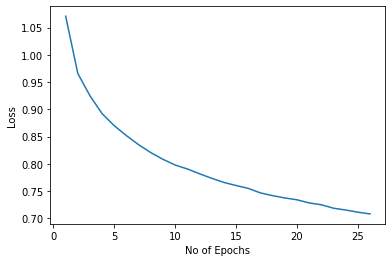

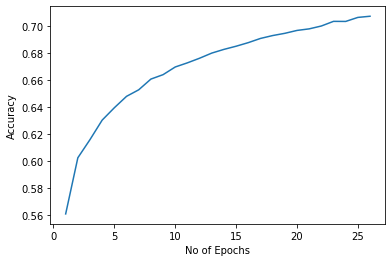

In [568]:
#Plot the training accuracy and loss
import matplotlib.pyplot as plt

training_dict = history.history
accuracy_val = training_dict['acc']
loss_val = training_dict['loss']
epochs = range(1, len(loss_val) + 1)
plt.figure()
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.plot(epochs,loss_val)
plt.savefig('Loss.png')
plt.figure()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.plot(epochs,accuracy_val)
plt.savefig('Accuracy.png')

In [0]:
# Save the model
model.save('1111017_1dconv_reg')

In [0]:
# load the model

from keras.models import load_model
model = load_model('1111017_1dconv_reg')

In [566]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6650


In [567]:
# Calculate Precision, Recall and F1 score.

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

from collections import Counter
rounded_labels=np.argmax(y_test, axis=1)
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)
print(y_pred)
precision = precision_score(rounded_labels, y_pred , average="macro")
print("The Precision is : %.4f" % precision)
recall = recall_score(rounded_labels, y_pred , average="macro")
print("The Recall is : %.4f" % recall)
f1_score = f1_score(rounded_labels, y_pred , average="macro")
print("The F1_score is : %.4f" % f1_score)

[1 3 3 ... 3 2 3]
The Precision is : 0.5963
The Recall is : 0.5373
The F1_score is : 0.5582
